# Figure M2 (methods)
### Temperature and Salinity diagrams at the model boundaries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import gsw
import xarray as xr
from math import sin, cos, sqrt, atan2, radians
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from constants import imin, imax, jmin, jmax, isize, jsize, \
                      rimwidthN, rimwidthS, rimwidthW, rimwidthE, \
                      bdy_NCB, bdy_WCB, bdy_LS, bdy_HB, \
                      land_color, light_land, land_edge, light_gray, \
                      path_figure

%matplotlib inline

#### Load files

In [6]:
# ANHA12 grid mesh:
mesh        = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
mesh_hdepw  = mesh['hdepw'].values[0,:,:]
mesh_mbathy = mesh['mbathy'].values[0,:,:]
gdepw1d     = mesh['gdepw_1d'].values

# And the Pb model configuration ANHA12 mask:
mask         = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20230213.nc')
mesh_lon     = mask.nav_lon.values
mesh_lat     = mask.nav_lat.values
mesh_bathy   = mask.tmask.values[0,:,:,:]
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)

Pb observations:

In [7]:
folder= '/ocean/brogalla/GEOTRACES/data/'

# ------ North Atlantic Ocean, Labrador Sea, Baffin Bay GEOTRACES data -----------
# Observations from: GEOTRACES Intermdiate Data Product, 2021
df_SW = xr.open_dataset(f'{folder}BB-NA-IDP2021_GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v1_mX0n8Urd.nc')
SW_ini_lons = df_SW['longitude'].values # degrees east
SW_ini_lats = df_SW['latitude'].values
SW_ini_pressure   = df_SW['var1'].values # pressure from CTD sensor in dbar
SW_ini_depths     = df_SW['var2'].values # depth below sea surface calculated from pressure
SW_ini_temp_C     = df_SW['var3'].values # temperature from CTD sensor in ITS-90 convention
SW_ini_sal_pss78  = df_SW['var4'].values # practical salinity from CTD sensor in PSS-1978 scale
SW_ini_dPb_pmolkg = df_SW['var9'].values # concentration of dissolved Pb in pmol/kg 
SW_ini_dPb_qc     = df_SW['var9_qc'].values # dPb quality control flag (49-good, 50-prob good, 51-prob bad, 52-bad)

SW_ini_lons_tile = np.tile(SW_ini_lons, (268,1)).transpose()
SW_ini_lats_tile = np.tile(SW_ini_lats, (268,1)).transpose()
# convert units
SW_ini_sal_abs    = gsw.conversions.SA_from_SP(SW_ini_sal_pss78, SW_ini_pressure, SW_ini_lons_tile, SW_ini_lats_tile) # absolute salinity
SW_ini_temp_cons  = gsw.conversions.CT_from_t(SW_ini_sal_abs, SW_ini_temp_C, SW_ini_pressure) # conservative temperature

SW_Pb_stns = np.array([])
for stn in range(0,len(SW_ini_lons)):
    if sum(~np.isnan(SW_ini_dPb_pmolkg[stn,:])) > 0: # count number of non NaN Pb values at this station
        SW_Pb_stns = np.append(SW_Pb_stns, stn)
        
# SW_Pb_stns contains the indices of stations that have Pb observations
SW_lons       = np.array([SW_ini_lons[int(i)] for i in SW_Pb_stns])
SW_lats       = np.array([SW_ini_lats[int(i)] for i in SW_Pb_stns])
SW_pres       = np.array([SW_ini_pressure[int(i),:] for i in SW_Pb_stns])
SW_dept       = np.array([SW_ini_depths[int(i),:] for i in SW_Pb_stns])
SW_temp       = np.array([SW_ini_temp_C[int(i),:] for i in SW_Pb_stns])
SW_sals       = np.array([SW_ini_sal_pss78[int(i),:] for i in SW_Pb_stns])
SW_dPb_pmolkg = np.array([SW_ini_dPb_pmolkg[int(i),:] for i in SW_Pb_stns])
SW_dPb_qc     = np.array([SW_ini_dPb_qc[int(i),:] for i in SW_Pb_stns])

#-- Unit conversions: ----
SW_lons_tile = np.tile(SW_lons, (268,1)).transpose()
SW_lats_tile = np.tile(SW_lats, (268,1)).transpose()
# practical salinity --> absolute salinity (g/kg)
SW_sal_abs   = gsw.conversions.SA_from_SP(SW_sals, SW_pres, SW_lons_tile, SW_lats_tile)
# calculate density: uses in situ temperature, absolute salinity, sea pressure 
SW_density   = gsw.density.rho_t_exact(SW_sal_abs, SW_temp, SW_pres) # kg/m3
SW_dPb_pmolL = SW_dPb_pmolkg * SW_density * 1e-3 # dPb in pmol/kg --> pmol/L

# Apply quality control flags (remove bad and probably bad values)
SW_dPb_pmolL[SW_dPb_qc == 51] = np.nan
SW_dPb_pmolL[SW_dPb_qc == 52] = np.nan

# calculate conservative temperature from in situ temperature:
SW_temp_cons = gsw.conversions.CT_from_t(SW_sal_abs, SW_temp, SW_pres)

In [8]:
# ------ Arctic Ocean data -----------
# Observations from: GEOTRACES IDP 2021
df_NW = xr.open_dataset(f'{folder}AO-IDP2021_GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v1_H8oFfvOt.nc')
NW_ini_lons = df_NW['longitude'].values # degrees east
NW_ini_lats = df_NW['latitude'].values
NW_ini_pressure   = df_NW['var1'].values # pressure from CTD sensor in dbar
NW_ini_depths     = df_NW['var2'].values # depth below sea surface calculated from pressure
NW_ini_temp_C     = df_NW['var3'].values # temperature from CTD sensor in ITS-90 convention
NW_ini_sal_pss78  = df_NW['var4'].values # practical salinity from CTD sensor in PSS-1978 scale
NW_ini_dPb_pmolkg = df_NW['var9'].values # concentration of dissolved Pb in pmol/kg 
NW_ini_dPb_qc     = df_NW['var9_qc'].values # dPb quality control flag (49-good, 50-prob good, 51-prob bad, 52-bad)

NW_ini_lons_tile = np.tile(NW_ini_lons, (345,1)).transpose()
NW_ini_lats_tile = np.tile(NW_ini_lats, (345,1)).transpose()
# convert units
NW_ini_sal_abs    = gsw.conversions.SA_from_SP(NW_ini_sal_pss78, NW_ini_pressure, NW_ini_lons_tile, NW_ini_lats_tile) # absolute salinity
NW_ini_temp_cons  = gsw.conversions.CT_from_t(NW_ini_sal_abs, NW_ini_temp_C, NW_ini_pressure) # conservative temperature

NW_Pb_stns = np.array([])
for stn in range(0,len(NW_ini_lons)):
    if sum(~np.isnan(NW_ini_dPb_pmolkg[stn,:])) > 0: # count number of non NaN Pb values at this station
        NW_Pb_stns = np.append(NW_Pb_stns, stn)
        
# SW_Pb_stns contains the indices of stations that have Pb observations
NW_lons       = np.array([NW_ini_lons[int(i)] for i in NW_Pb_stns])
NW_lats       = np.array([NW_ini_lats[int(i)] for i in NW_Pb_stns])
NW_pres       = np.array([NW_ini_pressure[int(i),:] for i in NW_Pb_stns])
NW_dept       = np.array([NW_ini_depths[int(i),:] for i in NW_Pb_stns])
NW_temp       = np.array([NW_ini_temp_C[int(i),:] for i in NW_Pb_stns])
NW_sals       = np.array([NW_ini_sal_pss78[int(i),:] for i in NW_Pb_stns])
NW_dPb_pmolkg = np.array([NW_ini_dPb_pmolkg[int(i),:] for i in NW_Pb_stns])
NW_dPb_qc     = np.array([NW_ini_dPb_qc[int(i),:] for i in NW_Pb_stns])

#-- Unit conversions: ----
NW_lons_tile = np.tile(NW_lons, (345,1)).transpose()
NW_lats_tile = np.tile(NW_lats, (345,1)).transpose()
# practical salinity --> absolute salinity (g/kg)
NW_sal_abs   = gsw.conversions.SA_from_SP(NW_sals, NW_pres, NW_lons_tile, NW_lats_tile)
# calculate density: uses in situ temperature, absolute salinity, sea pressure 
NW_density   = gsw.density.rho_t_exact(NW_sal_abs, NW_temp, NW_pres) # kg/m3
NW_dPb_pmolL = NW_dPb_pmolkg * NW_density * 1e-3 # dPb in pmol/kg --> pmol/L

# Apply quality control flags (remove bad and probably bad values)
NW_dPb_pmolL[NW_dPb_qc == 51] = np.nan
NW_dPb_pmolL[NW_dPb_qc == 52] = np.nan

# calculate conservative temperature from in situ temperature:
NW_temp_cons = gsw.conversions.CT_from_t(NW_sal_abs, NW_temp, NW_pres)

# Separate into northern Canada Basin and western Canada Basin:
nCB_dPb_pmolL = NW_dPb_pmolL[2:11,:]
nCB_sal_abs   = NW_sal_abs[2:11,:]
nCB_temp_cons = NW_temp_cons[2:11,:]
wCB_dPb_pmolL = np.vstack([NW_dPb_pmolL[1:4,:], NW_dPb_pmolL[17:21,:]])
wCB_sal_abs   = np.vstack([NW_sal_abs[1:4,:]  , NW_sal_abs[17:21,:]])
wCB_temp_cons = np.vstack([NW_temp_cons[1:4,:], NW_temp_cons[17:21,:]])

#### Functions

In [9]:
# Function loads climatology of temperature and salinity for the specified year and month
def load_climatology(year, month):        
    df_gridT = xr.open_dataset(f'/data/brogalla/ANHA12/new_averages/gridT_{year}_{month:02}.nc')
    
    bdy_temp = df_gridT['votemper'].values[:,:,:]
    bdy_sal  = df_gridT['vosaline'].values[:,:,:]
    
    return bdy_temp, bdy_sal

In [10]:
# Function converts latitudes and longituds to distance along transect
def calc_distance(lats, lons):
    R = 6373.0 # approximate radius of earth in km

    lats_rad = [radians(l) for l in lats]
    lons_rad = [radians(l) for l in lons]

    dlon = [lon_step - lons_rad[0] for lon_step in lons_rad]
    dlat = [lat_step - lats_rad[0] for lat_step in lats_rad]

    # calculate distance:
    distance = np.empty((len(dlon)))
    for i in range(0,len(dlon)):
        a = sin(dlat[i] / 2)**2 + cos(lats_rad[0]) * cos(lats_rad[i]) * sin(dlon[i] / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance[i] = R * c
        
    return distance

In [11]:
# Function creates a patch to mask land in the transect plots
def land_patch(distances, coordi, coordj, EW=True):
    
    topo = []
    for d, distance in enumerate(distances[0:-1]):
        if EW: # east-west
            rect = Rectangle((distance, mesh_hdepw[coordi,coordj+d]), distances[d+1]-distance, 5000)
        else:
            rect = Rectangle((distance, mesh_hdepw[coordi+d,coordj]), distances[d+1]-distance, 5000)
        topo.append(rect)

    pc = PatchCollection(topo, facecolors=land_color, edgecolors=land_color, alpha=1)
    return pc

#### Calculations

In [12]:
model_lons = np.tile(mesh_lon, (50,1,1))
model_lats = np.tile(mesh_lat, (50,1,1))
model_depths = np.moveaxis(np.tile(mask.nav_lev.values, (2400, 1632,1)),[2],[0])

In [13]:
year=2015
month=8

T, S = load_climatology(year, month)

# convert units from potential to conservative temperature and practical to absolute salinity
S_abs   = gsw.conversions.SA_from_SP(S, model_depths, model_lons, model_lats) # absolute salinity
T_cons  = gsw.conversions.CT_from_pt(S_abs, T) # conservative temperature

# Subset to the boundary locations
LS_T  = T_cons[:,bdy_LS[0]:bdy_LS[1],bdy_LS[2]:bdy_LS[3]]
LS_S  = S_abs[:,bdy_LS[0]:bdy_LS[1],bdy_LS[2]:bdy_LS[3]]
nCB_T = T_cons[:,bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]:bdy_NCB[3]]
nCB_S = S_abs[:,bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]:bdy_NCB[3]]
wCB_T = T_cons[:,bdy_WCB[0]:bdy_WCB[1],bdy_WCB[2]:bdy_WCB[3]]
wCB_S = S_abs[:,bdy_WCB[0]:bdy_WCB[1],bdy_WCB[2]:bdy_WCB[3]]
HB_T  = T_cons[:,bdy_HB[0]:bdy_HB[1],bdy_HB[2]:bdy_HB[3]] 
HB_S  = S_abs[:,bdy_HB[0]:bdy_HB[1],bdy_HB[2]:bdy_HB[3]]

Boundary conditions:

In [14]:
# Load the Pb model boundary condition
BC      = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/Pb-forcing-202311/bdy-reference/Pb_OBC_y2015m08.nc')
dPb_LS  = BC.dPb_S.values.reshape(50,rimwidthS,bdy_LS[3]-bdy_LS[2])
dPb_wCB = np.flip(BC.dPb_N.values.reshape(50,rimwidthN,bdy_WCB[3]-bdy_WCB[2]), axis=1)
dPb_nCB = np.flip(BC.dPb_E.values.reshape(50,rimwidthE,bdy_NCB[1]-bdy_NCB[0]), axis=1)
dPb_HB  = BC.dPb_W.values.reshape(50,rimwidthW,bdy_HB[1]-bdy_HB[0])

# Labrador Sea
dPb_LS_lons = mesh_lon[bdy_LS[0]:bdy_LS[1],bdy_LS[2]:bdy_LS[3]] 
dPb_LS_lats = mesh_lat[bdy_LS[0]:bdy_LS[1],bdy_LS[2]:bdy_LS[3]]
dPb_LS_mdepths = bathy_masked[:,bdy_LS[0]:bdy_LS[1],bdy_LS[2]:bdy_LS[3]]

# Northern Canada Basin
dPb_NCB_lons = mesh_lon[bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]:bdy_NCB[3]] 
dPb_NCB_lats = mesh_lat[bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]:bdy_NCB[3]] 
dPb_NCB_mdepths = bathy_masked[:,bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]:bdy_NCB[3]] 

# Western Canada Basin
dPb_WCB_lons = mesh_lon[bdy_WCB[0]:bdy_WCB[1],bdy_WCB[2]:bdy_WCB[3]] 
dPb_WCB_lats = mesh_lat[bdy_WCB[0]:bdy_WCB[1],bdy_WCB[2]:bdy_WCB[3]]
dPb_WCB_mdepths = bathy_masked[:,bdy_WCB[0]:bdy_WCB[1],bdy_WCB[2]:bdy_WCB[3]]

# Hudson Bay
dPb_HB_lons = mesh_lon[bdy_HB[0]:bdy_HB[1],bdy_HB[2]:bdy_HB[3]] 
dPb_HB_lats = mesh_lat[bdy_HB[0]:bdy_HB[1],bdy_HB[2]:bdy_HB[3]] 
dPb_HB_mdepths = bathy_masked[:,bdy_HB[0]:bdy_HB[1],bdy_HB[2]:bdy_HB[3]] 

BC.close()

In [15]:
bdy_cell=0

# Look at only one slice of the rimwidth thickness boundary:
LS_distance  = calc_distance(dPb_LS_lats[bdy_cell,:] , dPb_LS_lons[bdy_cell,:])    # Labrador Sea
WCB_distance = calc_distance(dPb_WCB_lats[bdy_cell,:], dPb_WCB_lons[bdy_cell,:])    # western CB
NCB_distance = calc_distance(dPb_NCB_lats[:,bdy_cell], dPb_NCB_lons[:,bdy_cell]) # northern CB
HB_distance  = calc_distance(dPb_HB_lats[:,bdy_cell] , dPb_HB_lons[:,bdy_cell]) # Hudson Bay

# and create patches to mask land in transects
LS_patch  = land_patch(LS_distance       , bdy_LS[0] , bdy_LS[2] , EW=True)
WCB_patch = land_patch(WCB_distance      , bdy_WCB[0], bdy_WCB[2], EW=True)
NCB_patch = land_patch(NCB_distance[::-1], bdy_NCB[0], bdy_NCB[2], EW=False)
HB_patch  = land_patch(HB_distance       , bdy_HB[0] , bdy_HB[2] , EW=False)

#### Figures

In [16]:
cmap_Pb = cmocean.cm.matter
vmin_AO = 0; vmax_AO = 15;
vmin_LS = 0; vmax_LS = 30;

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


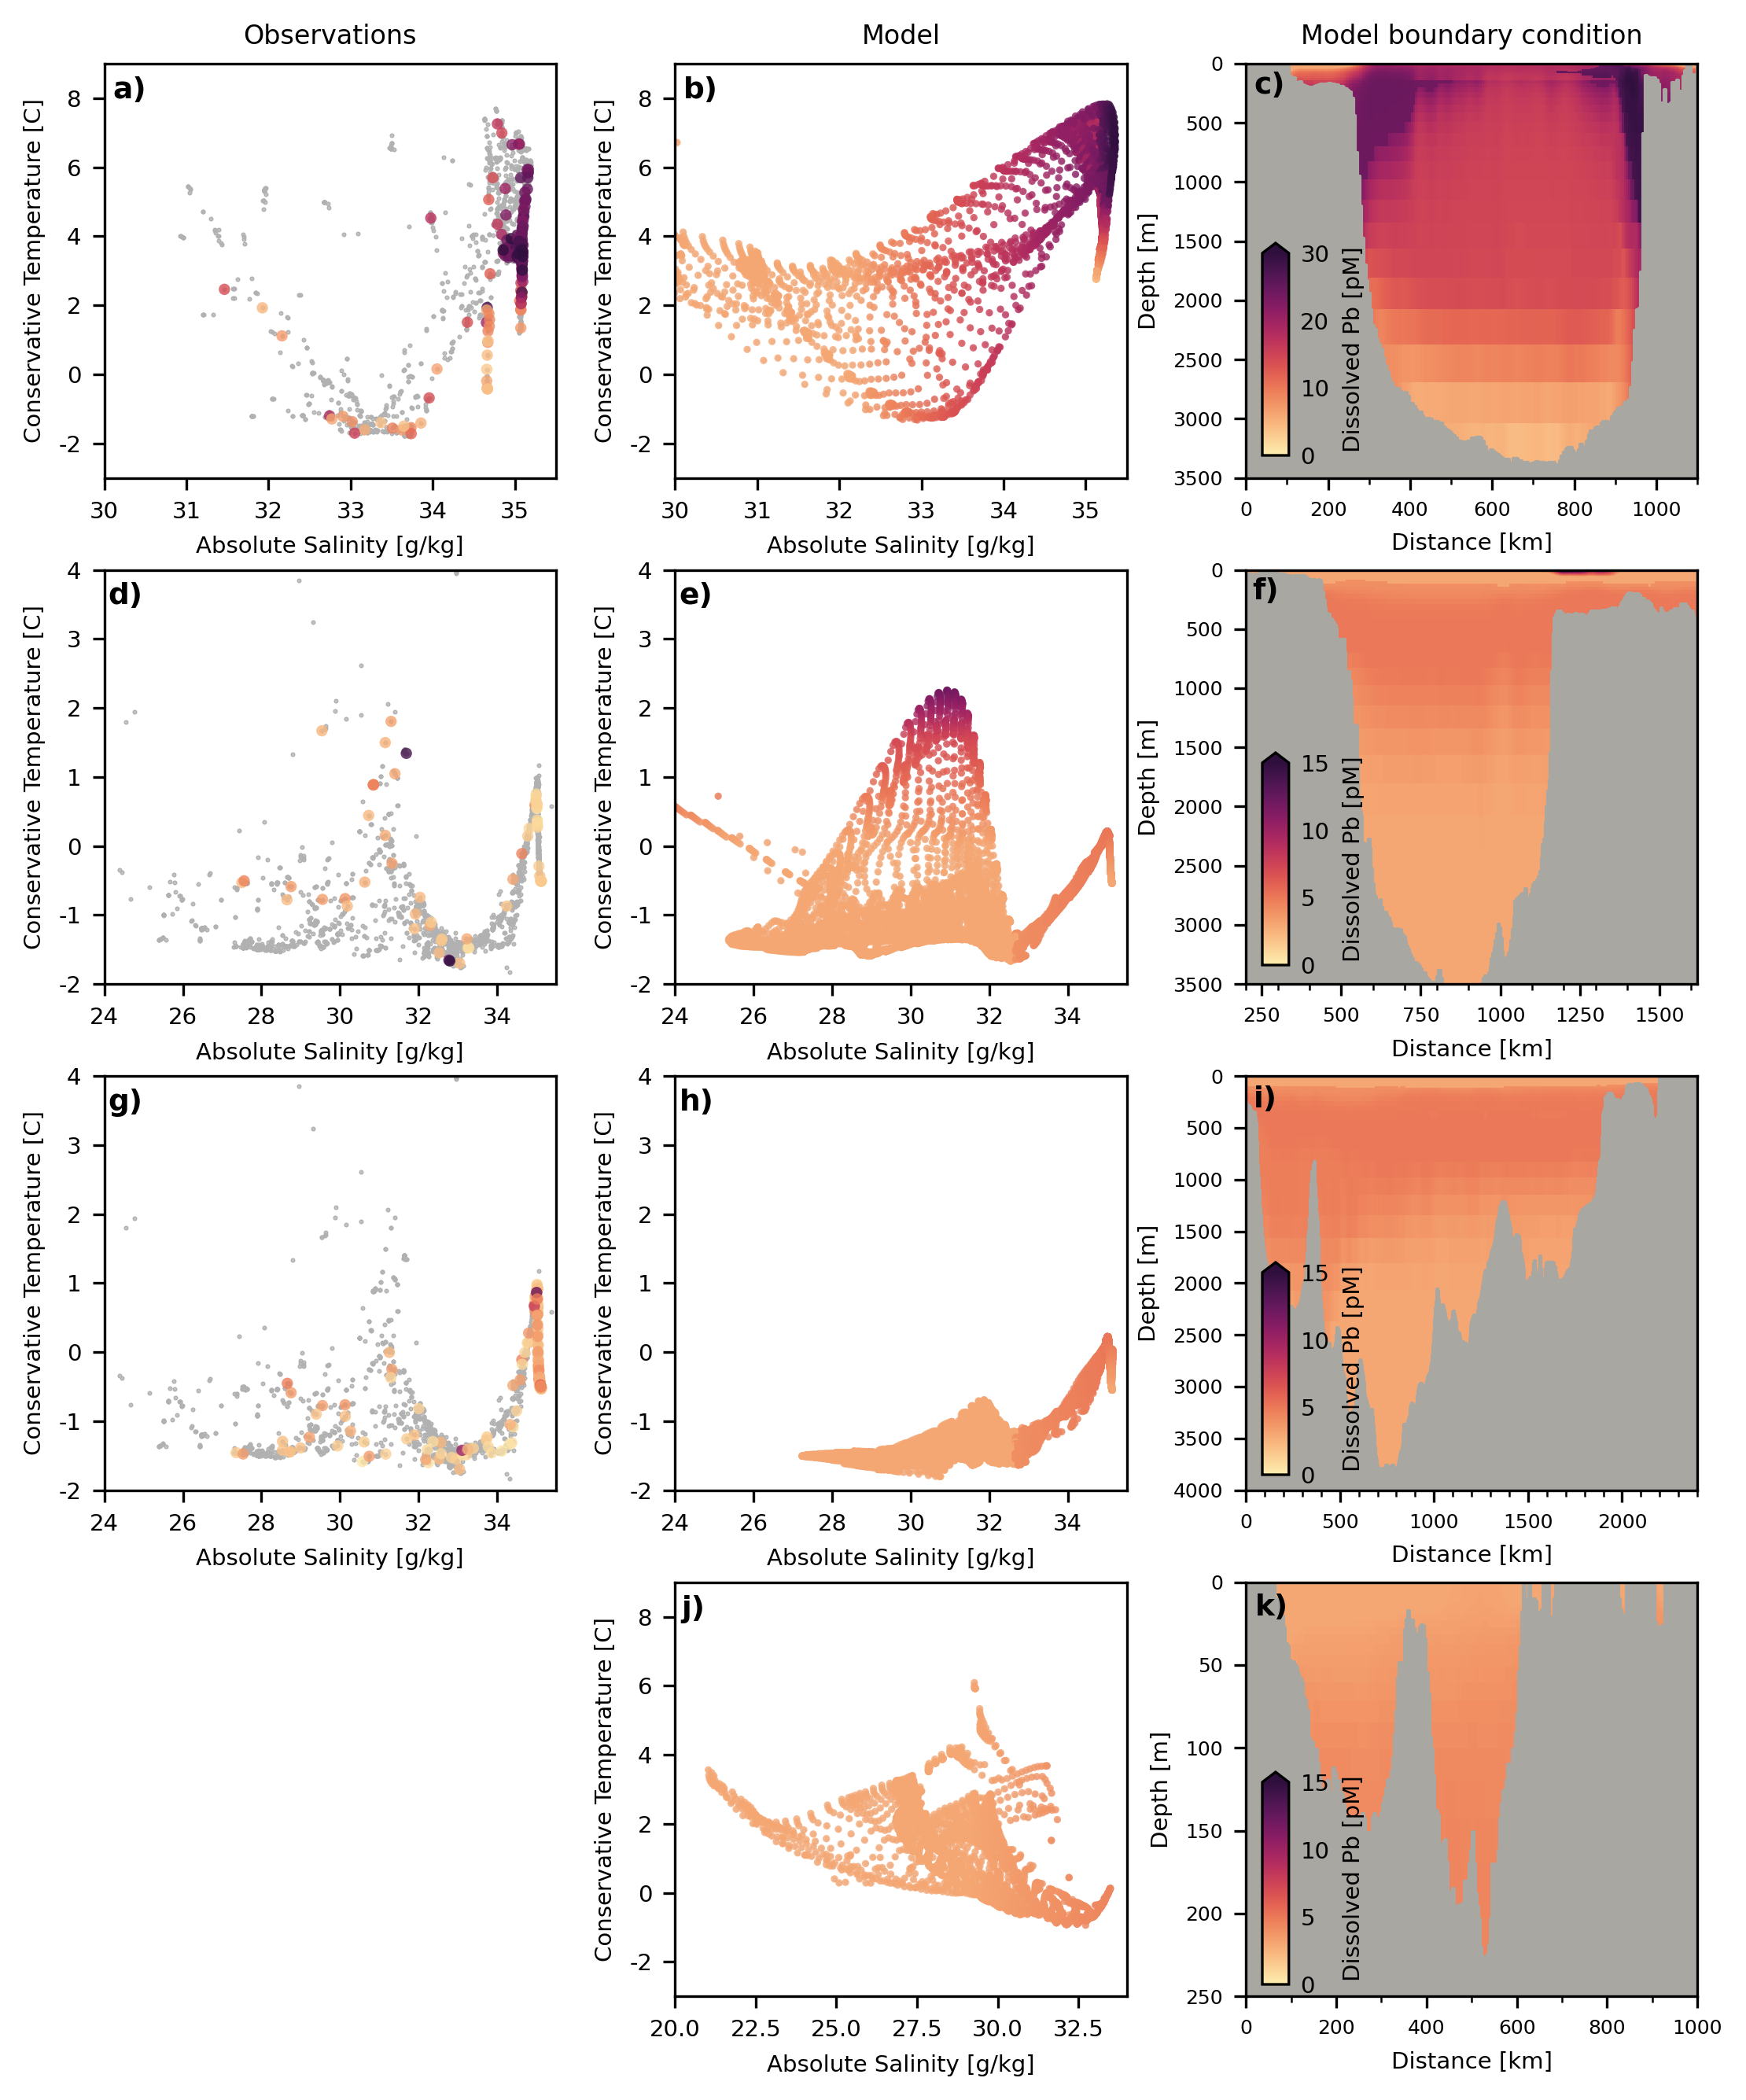

In [17]:
fig, ax = plt.subplots(4,3, figsize=(7.5,9), dpi=300)
       
# labelling
for n,axis in enumerate(ax[:,0:2].ravel()):
    axis.tick_params(axis='both', labelsize=7)
    axis.set_xlim(24, 35.5)
for axis in ax[:,0:2].ravel():
    axis.set_ylabel('Conservative Temperature [C]', fontsize=7)
    axis.set_xlabel('Absolute Salinity [g/kg]', fontsize=7)
    axis.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
for axis in ax[:,2].ravel():
    axis.set_ylabel('Depth [m]', fontsize=7)
    axis.set_xlabel('Distance [km]', fontsize=7)
    
ax[0,0].set_title('Observations', fontsize=8)
ax[0,1].set_title('Model', fontsize=8)
ax[0,2].set_title('Model boundary condition', fontsize=8)
ax[0,0].text(30.1, 8   ,'a)', fontsize=9, weight='bold'); ax[0,1].text(30.1, 8 , 'b)', fontsize=9, weight='bold');
ax[0,2].text(20  ,250  ,'c)', fontsize=9, weight='bold');
ax[1,0].text(24.1, 3.5 ,'d)', fontsize=9, weight='bold'); ax[1,1].text(24.1, 3.5, 'e)', fontsize=9, weight='bold');
ax[1,2].text(220 ,250  ,'f)', fontsize=9, weight='bold');
ax[2,0].text(24.1, 3.5 ,'g)', fontsize=9, weight='bold'); ax[2,1].text(24.1, 3.5, 'h)', fontsize=9, weight='bold');
ax[2,2].text(40, 300   ,'i)', fontsize=9, weight='bold'); 
ax[3,1].text(20.2, 8   ,'j)', fontsize=9, weight='bold'); ax[3,2].text(20, 20   , 'k)', fontsize=9, weight='bold');
ax[3,0].axis('off'); 

# axis limits
ax[0,0].set_ylim(-3,9); ax[0,1].set_ylim(-3,9); ax[1,0].set_ylim(-2,4); ax[1,1].set_ylim(-2,4);
ax[2,0].set_ylim(-2,4); ax[2,1].set_ylim(-2,4); ax[3,1].set_ylim(-3,9)
ax[0,0].set_xlim(30,35.5); ax[0,1].set_xlim(30,35.5); ax[3,1].set_xlim(20,34)

#----- Observations: ----------------------------------------------------
ax[0,0].scatter(SW_ini_sal_abs.flatten(), SW_ini_temp_cons.flatten(), c=light_gray, s=0.2, zorder=2, alpha=1)
CB1 = ax[0,0].scatter(SW_sal_abs.flatten(), SW_temp_cons.flatten(), c=SW_dPb_pmolL, \
           alpha=0.8, s=12, edgecolor='k', linewidth=0.0, zorder=3, vmin=vmin_LS, vmax=vmax_LS, cmap=cmap_Pb)

ax[1,0].scatter(NW_ini_sal_abs.flatten(), NW_ini_temp_cons.flatten(), c=light_gray, s=0.2, zorder=2, alpha=1)
CB2 = ax[1,0].scatter(wCB_sal_abs.flatten(), wCB_temp_cons.flatten(), c=wCB_dPb_pmolL, \
           alpha=0.8, s=12, edgecolor='k', linewidth=0.0, zorder=3, vmin=vmin_AO, vmax=vmax_AO, cmap=cmap_Pb)

ax[2,0].scatter(NW_ini_sal_abs.flatten(), NW_ini_temp_cons.flatten(), c=light_gray, s=0.2, zorder=2, alpha=1)
CB3 = ax[2,0].scatter(nCB_sal_abs.flatten(), nCB_temp_cons.flatten(), c=nCB_dPb_pmolL, \
           alpha=0.8, s=12, edgecolor='k', linewidth=0.0, zorder=3, vmin=vmin_AO, vmax=vmax_AO, cmap=cmap_Pb)

#----- Model: -----------------------------------------------------------
layer  = 0
top    = 0
ax[0,1].scatter(LS_S[:,layer,:] , LS_T[:,layer,:] , c=light_gray, s=0.1, zorder=1, alpha=0.6)
ax[1,1].scatter(wCB_S[:,layer,:], wCB_T[:,layer,:], c=light_gray, s=0.1, zorder=1, alpha=0.6)
ax[2,1].scatter(nCB_S[:,:,layer], nCB_T[:,:,layer], c=light_gray, s=0.1, zorder=1, alpha=0.6)
ax[3,1].scatter(HB_S[:,:,layer] , HB_T[:,:,layer] , c=light_gray, s=0.1, zorder=1, alpha=0.6)

CB4 = ax[0,1].scatter(LS_S[top:,layer,:] , LS_T[top:,layer,:] , c=dPb_LS[top:,layer,:]*1e12, \
                alpha=0.8, s=5, edgecolor='k', linewidth=0.0, zorder=2, vmin=vmin_LS, vmax=vmax_LS, cmap=cmap_Pb)
CB5 = ax[1,1].scatter(wCB_S[top:,layer,:], wCB_T[top:,layer,:], c=dPb_wCB[top:,layer,:]*1e12, \
                alpha=0.8, s=5, edgecolor='k', linewidth=0.0, zorder=2, vmin=vmin_AO, vmax=vmax_AO, cmap=cmap_Pb)
CB6 = ax[2,1].scatter(nCB_S[top:,:,layer], nCB_T[top:,:,layer], c=dPb_nCB[top:,layer,:]*1e12, \
                alpha=0.8, s=5, edgecolor='k', linewidth=0.0, zorder=2, vmin=vmin_AO, vmax=vmax_AO, cmap=cmap_Pb)
CB7 = ax[3,1].scatter(HB_S[top:,:,layer], HB_T[top:,:,layer], c=dPb_HB[top:,layer,:]*1e12, \
                alpha=0.8, s=5, edgecolor='k', linewidth=0.0, zorder=2, vmin=vmin_AO, vmax=vmax_AO, cmap=cmap_Pb)

# ---------------------------------------------------------------------------------------
# transect:
for axis in ax[:,2].ravel():
    axis.invert_yaxis()
    axis.tick_params(axis='both', which='major', labelsize=6)
    axis.xaxis.set_minor_locator(MultipleLocator(100))
    
# Labrador Sea:
xx, zz = np.meshgrid(LS_distance, gdepw1d)
CB1 = ax[0,2].pcolormesh(xx, zz, dPb_LS[:,layer,:]*1e12, vmin=vmin_LS, vmax=vmax_LS, cmap=cmap_Pb)
ax[0,2].add_collection(LS_patch)
ax[0,2].set_xlim(0,1100)    
ax[0,2].set_ylim(3500,0)

# Western Canada Basin:
xx, zz = np.meshgrid(WCB_distance, gdepw1d)
CB3 = ax[1,2].pcolormesh(xx, zz, dPb_wCB[:,layer,:]*1e12, vmin=vmin_AO, vmax=vmax_AO, cmap=cmap_Pb)
ax[1,2].add_collection(WCB_patch)
ax[1,2].set_ylim(3500,0)
ax[1,2].set_xlim(200,1620)

# Northern Canada Basin:
xx, zz = np.meshgrid(NCB_distance[::-1], gdepw1d)
CB2 = ax[2,2].pcolormesh(xx, zz, dPb_nCB[:,layer,:]*1e12, vmin=vmin_AO, vmax=vmax_AO, cmap=cmap_Pb)
ax[2,2].add_collection(NCB_patch)
ax[2,2].set_ylim(4000,0)

# Hudson Bay: 
xx, zz = np.meshgrid(HB_distance, gdepw1d)
CB4 = ax[3,2].pcolormesh(xx, zz, dPb_HB[:,layer,:]*1e12, vmin=vmin_AO, vmax=vmax_AO, cmap=cmap_Pb)
ax[3,2].add_collection(HB_patch)
ax[3,2].set_ylim(250,0)
ax[3,2].set_xlim(0,1000)
 
cbax1 = fig.add_axes([0.72, 0.78, 0.015, 0.1]); cbax2 = fig.add_axes([0.72, 0.54, 0.015, 0.1]);
cbax3 = fig.add_axes([0.72, 0.30, 0.015, 0.1]); cbax4 = fig.add_axes([0.72, 0.06, 0.015, 0.1]);
cbaxes = [cbax1, cbax2, cbax3, cbax4]
for n,cb in enumerate([CB1, CB2, CB3, CB4]):
    CBar = plt.colorbar(cb, ax=ax, cax=cbaxes[n], extend='max'); 
    CBar.set_label('Dissolved Pb [pM]', fontsize=7)
    CBar.ax.tick_params(axis='y', length=0, labelsize=7)
    
#adjust figure spacing (the warning that is printed out only affects spacing, nothing else)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
    
fig.savefig(f'{path_figure}M2-boundary.jpg', dpi=300, bbox_inches='tight')